# Seminar 2. Training networks in PyTorch

On this seminar, we will train Lenet-5 on a MNIST dataset using PyTorch.

In [1]:
import torch
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from tqdm import tqdm

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba

<ipython-input-1-5a2f1225f536>:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


## Learning by example: Continuous XOR

If we want to build a neural network in PyTorch, we could specify all our parameters (weight matrices, bias vectors) using `Tensors` (with `requires_grad=True`), ask PyTorch to calculate the gradients and then adjust the parameters. But things can quickly get cumbersome if we have a lot of parameters. In PyTorch, there is a package called `torch.nn` that makes building neural networks more convenient.

We will introduce the libraries and all additional parts you might need to train a neural network in PyTorch, using a simple example classifier on a simple yet well known example: XOR. Given two binary inputs $x_1$ and $x_2$, the label to predict is $1$ if either $x_1$ or $x_2$ is $1$ while the other is $0$, or the label is $0$ in all other cases. The example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function.
Hence, we will learn how to build a small neural network that can learn this function.
To make it a little bit more interesting, we move the XOR into continuous space and introduce some gaussian noise on the binary inputs. Our desired separation of an XOR dataset could look as follows:

<center style="width: 100%"><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/continuous_xor.svg" width="350px"></center>

### The model

The package `torch.nn` defines a series of useful classes like linear networks layers, activation functions, loss functions etc. A full list can be found [here](https://pytorch.org/docs/stable/nn.html). In case you need a certain network layer, check the documentation of the package first before writing the layer yourself as the package likely contains the code for it already. We import it below:

In [2]:
import torch.nn as nn

Additionally to `torch.nn`, there is also `torch.nn.functional`. It contains functions that are used in network layers. This is in contrast to `torch.nn` which defines them as `nn.Modules` (more on it below), and `torch.nn` actually uses a lot of functionalities from `torch.nn.functional`. Hence, the functional package is useful in many situations, and so we import it as well here.

In [3]:
import torch.nn.functional as F

#### nn.Module

In PyTorch, a neural network is built up out of modules. Modules can contain other modules, and a neural network is considered to be a module itself as well. The basic template of a module is as follows:

In [ ]:
class MyModule(nn.Module):

    def __init__(self):
        super().__init__()
        # Some init for my module
        self.lin = nn.Linear

    def forward(self, x):
        # Function for performing the calculation of the module.
        return self.lin(x)

The forward function is where the computation of the module is taken place, and is executed when you call the module (`nn = MyModule(); nn(x)`). In the init function, we usually create the parameters of the module, using `nn.Parameter`, or defining other modules that are used in the forward function. The backward calculation is done automatically, but could be overwritten as well if wanted.

#### Simple classifier
We can now make use of the pre-defined modules in the `torch.nn` package, and define our own small neural network. We will use a minimal network with a input layer, one hidden layer with tanh as activation function, and a output layer. In other words, our networks should look something like this:

<center width="100%"><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/small_neural_network.svg" width="300px"></center>

The input neurons are shown in blue, which represent the coordinates $x_1$ and $x_2$ of a data point. The hidden neurons including a tanh activation are shown in white, and the output neuron in red.
In PyTorch, we can define this as follows:

In [5]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

For the examples in this notebook, we will use a tiny neural network with two input neurons and four hidden neurons. As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, are more efficient and precise to calculate on the original outputs instead of the sigmoid output. We will discuss the detailed reason later.

In [6]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


Printing the model lists all submodules it contains. The parameters of a module can be obtained by using its `parameters()` functions, or `named_parameters()` to get a name to each parameter object. For our small neural network, we have the following parameters:

In [7]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


Each linear layer has a weight matrix of the shape `[output, input]`, and a bias of the shape `[output]`. The tanh activation function does not have any parameters. Note that parameters are only registered for `nn.Module` objects that are direct object attributes, i.e. `self.a = ...`. If you define a list of modules, the parameters of those are not registered for the outer module and can cause some issues when you try to optimize your module. There are alternatives, like `nn.ModuleList`, `nn.ModuleDict` and `nn.Sequential`, that allow you to have different data structures of modules. We will use them in a few later tutorials and explain them there.

### The data

PyTorch also provides a few functionalities to load the training and test data efficiently, summarized in the package `torch.utils.data`.

In [8]:
import torch.utils.data as data

The data package defines two classes which are the standard interface for handling data in PyTorch: `data.Dataset`, and `data.DataLoader`. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.

#### The dataset class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: `__getitem__`, and `__len__`. The get-item function has to return the $i$-th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:

In [9]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

Let's try to create such a dataset and inspect it:

In [10]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([-0.0693,  1.0196]), tensor(1))


To better relate to the dataset, we visualize the samples below.

In [11]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

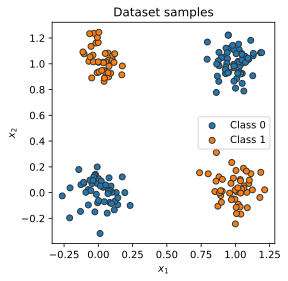

In [12]:
visualize_samples(dataset.data, dataset.label)
plt.show()

#### The data loader class

The class `torch.utils.data.DataLoader` represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function `__getitem__`, and stacks its outputs as tensors over the first dimension to form a batch.
In contrast to the dataset class, we usually don't have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments (only a selection, see full list [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)):

* `batch_size`: Number of samples to stack per batch
* `shuffle`: If True, the data is returned in a random order. This is important during training for introducing stochasticity.
* `num_workers`: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.
* `pin_memory`: If True, the data loader will copy Tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.
* `drop_last`: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.

Let's create a simple data loader below:

In [14]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

In [15]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 0.0998,  0.0028],
        [-0.0320,  1.2365],
        [-0.1300, -0.1465],
        [-0.0739,  0.0231],
        [ 1.0080,  0.0226],
        [ 0.0712,  1.0828],
        [ 1.0471,  0.0259],
        [ 1.1018,  0.0962]])
Data labels torch.Size([8]) 
 tensor([0, 1, 0, 0, 1, 1, 1, 1])


### Optimization

After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the gradients

We have seen how we can do step 1, 2 and 4 in PyTorch. Now, we will look at step 3 and 5.

#### Loss modules

We can calculate the loss for a batch by simply performing a few tensor operations as those are automatically added to the computation graph. For instance, for binary classification, we can use Binary Cross Entropy (BCE) which is defined as follows:

$$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$

where $y$ are our labels, and $x$ our predictions, both in the range of $[0,1]$. However, PyTorch already provides a list of predefined loss functions which we can use (see [here](https://pytorch.org/docs/stable/nn.html#loss-functions) for a full list). For instance, for BCE, PyTorch has two modules: `nn.BCELoss()`, `nn.BCEWithLogitsLoss()`. While `nn.BCELoss` expects the inputs $x$ to be in the range $[0,1]$, i.e. the output of a sigmoid, `nn.BCEWithLogitsLoss` combines a sigmoid layer and the BCE loss in a single class. This version is numerically more stable than using a plain Sigmoid followed by a BCE loss because of the logarithms applied in the loss function. Hence, it is adviced to use loss functions applied on "logits" where possible (remember to not apply a sigmoid on the output of the model in this case!). For our model defined above, we therefore use the module `nn.BCEWithLogitsLoss`.

In [16]:
loss_module = nn.BCEWithLogitsLoss()

#### Stochastic Gradient Descent

For updating the parameters, PyTorch provides the package `torch.optim` that has most popular optimizers implemented. We will discuss the specific optimizers and their differences later in the course, but will for now use the simplest of them: `torch.optim.SGD`. Stochastic Gradient Descent updates parameters by multiplying the gradients with a small constant, called learning rate, and subtracting those from the parameters (hence minimizing the loss). Therefore, we slowly move towards the direction of minimizing the loss. A good default value of the learning rate for a small network as ours is 0.1.

In [24]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

The optimizer provides two useful functions: `optimizer.step()`, and `optimizer.zero_grad()`. The step function updates the parameters based on the gradients as explained above. The function `optimizer.zero_grad()` sets the gradients of all parameters to zero. While this function seems less relevant at first, it is a crucial pre-step before performing backpropagation. If we call the `backward` function on the loss while the parameter gradients are non-zero from the previous batch, the new gradients would actually be added to the previous ones instead of overwriting them. This is done because a parameter might occur multiple times in a computation graph, and we need to sum the gradients in this case instead of replacing them. Hence, remember to call `optimizer.zero_grad()` before calculating the gradients of a batch.

### Training

Finally, we are ready to train our model. As a first step, we create a slightly larger dataset and specify a data loader with a larger batch size.

In [19]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

Now, we can write a small training function. Remember our five steps: load a batch, obtain the predictions, calculate the loss, backpropagate, and update. Additionally, we have to push all data and model parameters to the device of our choice (GPU if available). For the tiny neural network we have, communicating the data to the GPU actually takes much more time than we could save from running the operation on GPU. For large networks, the communication time is significantly smaller than the actual runtime making a GPU crucial in these cases. Still, to practice, we will push the data to GPU here.

In [21]:
# Push model to device. Has to be only done once
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In addition, we set our model to training mode. This is done by calling `model.train()`. There exist certain modules that need to perform a different forward step during training than during testing (e.g. BatchNorm and Dropout), and we can switch between them using `model.train()` and `model.eval()`.

In [22]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()


In [25]:
train_model(model, optimizer, train_data_loader, loss_module)

100%|██████████| 100/100 [00:03<00:00, 31.61it/s]


#### Saving a model

After finish training a model, we save the model to disk so that we can load the same weights at a later time. For this, we extract the so-called `state_dict` from the model which contains all learnable parameters. For our simple model, the state dict contains the following entries:

In [26]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-1.3185,  1.8404],
        [-1.4180,  0.8934],
        [-3.1140, -3.2848],
        [-2.1314, -1.9082]])), ('linear1.bias', tensor([ 0.8441, -0.5630,  1.4735,  3.0094])), ('linear2.weight', tensor([[-2.4195,  2.0359, -4.5060,  4.0198]])), ('linear2.bias', tensor([-1.5373]))])


To save the state dictionary, we can use `torch.save`:

In [27]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

To load a model from a state dict, we use the function `torch.load` to load the state dict from the disk, and the module function `load_state_dict` to overwrite our parameters with the new values:

In [28]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[-1.3185,  1.8404],
        [-1.4180,  0.8934],
        [-3.1140, -3.2848],
        [-2.1314, -1.9082]])), ('linear1.bias', tensor([ 0.8441, -0.5630,  1.4735,  3.0094])), ('linear2.weight', tensor([[-2.4195,  2.0359, -4.5060,  4.0198]])), ('linear2.bias', tensor([-1.5373]))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[-1.3185,  1.8404],
        [-1.4180,  0.8934],
        [-3.1140, -3.2848],
        [-2.1314, -1.9082]])), ('linear1.bias', tensor([ 0.8441, -0.5630,  1.4735,  3.0094])), ('linear2.weight', tensor([[-2.4195,  2.0359, -4.5060,  4.0198]])), ('linear2.bias', tensor([-1.5373]))])


A detailed tutorial on saving and loading models in PyTorch can be found [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

### Evaluation

Once we have trained a model, it is time to evaluate it on a held-out test set. As our dataset consist of randomly generated data points, we need to first create a test set with a corresponding data loader.

In [29]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

As metric, we will use accuracy which is calculated as follows:

$$acc = \frac{\#\text{correct predictions}}{\#\text{all predictions}} = \frac{TP+TN}{TP+TN+FP+FN}$$

where TP are the true positives, TN true negatives, FP false positives, and FN the fale negatives.

When evaluating the model, we don't need to keep track of the computation graph as we don't intend to calculate the gradients. This reduces the required memory and speed up the model. In PyTorch, we can deactivate the computation graph using `with torch.no_grad(): ...`. Remember to additionally set the model to eval mode.

In [30]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)

            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [31]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


If we trained our model correctly, we should see a score close to 100% accuracy. However, this is only possible because of our simple task, and unfortunately, we usually don't get such high scores on test sets of more complex tasks.

#### Visualizing classification boundaries

To visualize what our model has learned, we can perform a prediction for every data point in a range of $[-0.5, 1.5]$, and visualize the predicted class as in the sample figure at the beginning of this section. This shows where the model has created decision boundaries, and which points would be classified as $0$, and which as $1$. We therefore get a background image out of blue (class 0) and orange (class 1). The spots where the model is uncertain we will see a blurry overlap. The specific code is less relevant compared to the output figure which should hopefully show us a clear separation of classes:

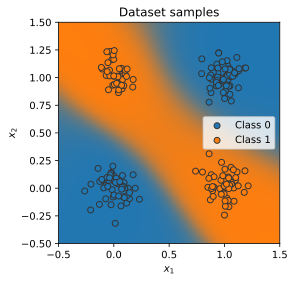

In [32]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

The decision boundaries might not look exactly as in the figure in the preamble of this section which can be caused by running it on CPU or a different GPU architecture. Nevertheless, the result on the accuracy metric should be the approximately the same.

### Initialization

In this tutorial, we will review techniques for optimization and initialization of neural networks. When increasing the depth of neural networks, there are various challenges we face. Most importantly, we need to have a stable gradient flow through the network, as otherwise, we might encounter vanishing or exploding gradients. This is why we will take a closer look at the following concepts: initialization and optimization.

In the first half of the notebook, we will review different initialization techniques, and go step by step from the simplest initialization to methods that are nowadays used in very deep networks. In the second half, we focus on optimization comparing the optimizers SGD, SGD with Momentum, and Adam.

Let's start with importing our standard libraries:

In [40]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

<ipython-input-40-eab9a83ee4d9>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


We will use the same `set_seed` function as in Tutorial 3, as well as the path variables `DATASET_PATH` and `CHECKPOINT_PATH`. Adjust the paths if necessary.

In [41]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial4"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


In the last part of the notebook, we will train models using three different optimizers. The pretrained models for those are downloaded below.

In [42]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Preparation

Throughout this notebook, we will use a deep fully connected network, similar to our previous tutorial. We will also again apply the network to FashionMNIST, so you can relate to the results of Tutorial 3.
We start by loading the FashionMNIST dataset:

In [43]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.2861,), (0.3530,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

100%|██████████| 26421880/26421880 [00:02<00:00, 13095353.93it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 297273.00it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5517026.02it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11061617.31it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In comparison to the previous tutorial, we have changed the parameters of the normalization transformation `transforms.Normalize`. The normalization is now designed to give us an expected mean of 0 and a standard deviation of 1 across pixels. This will be particularly relevant for the discussion about initialization we will look at below, and hence we change it here. It should be noted that in most classification tasks, both normalization techniques (between -1 and 1 or mean 0 and stddev 1) have shown to work well.
We can calculate the normalization parameters by determining the mean and standard deviation on the original images:

In [44]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.2860405743122101
Std 0.3530242443084717


We can verify the transformation by looking at the statistics of a single batch:

In [45]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.020
Standard deviation: 1.011
Maximum: 2.022
Minimum: -0.810


Note that the maximum and minimum are not 1 and -1 anymore, but shifted towards the positive values. This is because FashionMNIST contains a lot of black pixels, similar to MNIST.

Next, we create a linear neural network. We use the same setup as in the previous tutorial.

In [47]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.ModuleList(layers) # A module list registers a list of modules as submodules (e.g. for parameters)

        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            x = l(x)
        return x

For the activation functions, we make use of PyTorch's `torch.nn` library instead of implementing ourselves. However, we also define an `Identity` activation function. Although this activation function would significantly limit the network's modeling capabilities, we will use it in the first steps of our discussion about initialization (for simplicity).

In [48]:
class Identity(nn.Module):
    def forward(self, x):
        return x

act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": Identity
}

Finally, we define a few plotting functions that we will use for our discussions. These functions help us to (1) visualize the weight/parameter distribution inside a network, (2) visualize the gradients that the parameters at different layers receive, and (3) the activations, i.e. the output of the linear layers. The detailed code is not important, but feel free to take a closer look if interested.

In [49]:
##############################################################

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

##############################################################

def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

##############################################################

def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels) # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

## Initialization

Before starting our discussion about initialization, it should be noted that there exist many very good blog posts about the topic of neural network initialization (for example [deeplearning.ai](https://www.deeplearning.ai/ai-notes/initialization/), or a more [math-focused blog post](https://pouannes.github.io/blog/initialization/#mjx-eqn-eqfwd_K)). In case something remains unclear after this tutorial, we recommend skimming through these blog posts as well.

When initializing a neural network, there are a few properties we would like to have. First, the variance of the input should be propagated through the model to the last layer, so that we have a similar standard deviation for the output neurons. If the variance would vanish the deeper we go in our model, it becomes much harder to optimize the model as the input to the next layer is basically a single constant value. Similarly, if the variance increases, it is likely to explode (i.e. head to infinity) the deeper we design our model. The second property we look out for in initialization techniques is a gradient distribution with equal variance across layers. If the first layer receives much smaller gradients than the last layer, we will have difficulties in choosing an appropriate learning rate.

As a starting point for finding a good method, we will analyze different initialization based on our linear neural network with no activation function (i.e. an identity). We do this because initializations depend on the specific activation function used in the network, and we can adjust the initialization schemes later on for our specific choice.

In [50]:
model = BaseNetwork(act_fn=Identity()).to(device)

### Constant initialization

The first initialization we can consider is to initialize all weights with the same constant value. Intuitively, setting all weights to zero is not a good idea as the propagated gradient will be zero. However, what happens if we set all weights to a value slightly larger or smaller than 0? To find out, we can implement a function for setting all parameters below and visualize the gradients.

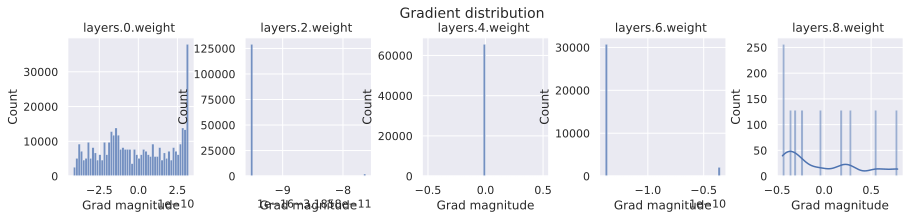

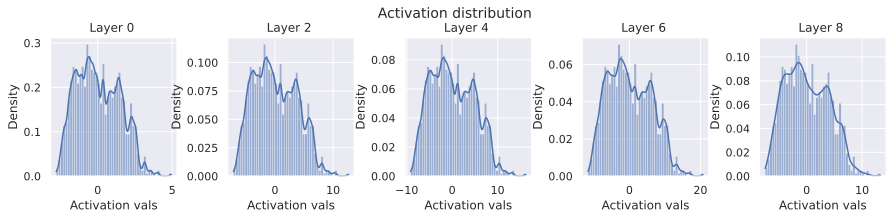

Layer 0 - Variance: 2.0582759380340576
Layer 2 - Variance: 13.489117622375488
Layer 4 - Variance: 22.100563049316406
Layer 6 - Variance: 36.209564208984375
Layer 8 - Variance: 14.831436157226562


In [51]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(c)

const_init(model, c=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

As we can see, only the first and the last layer have diverse gradient distributions while the other three layers have the same gradient for all weights (note that this value is unequal 0, but often very close to it). Having the same gradient for parameters that have been initialized with the same values means that we will always have the same value for those parameters. This would make our layer useless and reduce our effective number of parameters to 1. Thus, we cannot use a constant initialization to train our networks.

### Constant variance

From the experiment above, we have seen that a constant value is not working. So instead, how about we initialize the parameters by randomly sampling from a distribution like a Gaussian? The most intuitive way would be to choose one variance that is used for all layers in the network. Let's implement it below, and visualize the activation distribution across layers.

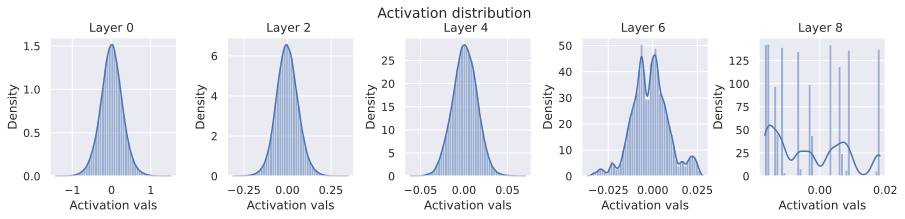

Layer 0 - Variance: 0.0797550156712532
Layer 2 - Variance: 0.004043167922645807
Layer 4 - Variance: 0.00020179587590973824
Layer 6 - Variance: 0.00010514973837416619
Layer 8 - Variance: 0.00012290490849409252


In [52]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)

var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

The variance of the activation becomes smaller and smaller across layers, and almost vanishes in the last layer. Alternatively, we could use a higher standard deviation:

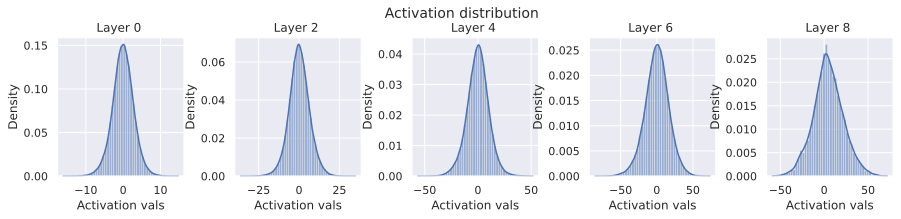

Layer 0 - Variance: 8.017800331115723
Layer 2 - Variance: 39.69389724731445
Layer 4 - Variance: 103.65348815917969
Layer 6 - Variance: 266.9234924316406
Layer 8 - Variance: 294.9678955078125


In [53]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

With a higher standard deviation, the activations are likely to explode. You can play around with the specific standard deviation values, but it will be hard to find one that gives us a good activation distribution across layers and is very specific to our model. If we would change the hidden sizes or number of layers, you would have to search all over again, which is neither efficient nor recommended.

### How to find appropriate initialization values

From our experiments above, we have seen that we need to sample the weights from a distribution, but are not sure which one exactly. As a next step, we will try to find the optimal initialization from the perspective of the activation distribution. For this, we state two requirements:

1. The mean of the activations should be zero
2. The variance of the activations should stay the same across every layer

Suppose we want to design an initialization for the following layer: $y=Wx+b$ with $y\in\mathbb{R}^{d_y}$, $x\in\mathbb{R}^{d_x}$. Our goal is that the variance of each element of $y$ is the same as the input, i.e. $\text{Var}(y_i)=\text{Var}(x_i)=\sigma_x^{2}$, and that the mean is zero. We assume $x$ to also have a mean of zero, because, in deep neural networks, $y$ would be the input of another layer. This requires the bias and weight to have an expectation of 0. Actually, as $b$ is a single element per output neuron and is constant across different inputs, we set it to 0 overall.

Next, we need to calculate the variance with which we need to initialize the weight parameters.
Along the calculation, we will need the following variance rule: given two independent variables, the variance of their product is $\text{Var}(X\cdot Y) = \mathbb{E}(Y)^2\text{Var}(X) + \mathbb{E}(X)^2\text{Var}(Y) + \text{Var}(X)\text{Var}(Y) = \mathbb{E}(Y^2)\mathbb{E}(X^2)-\mathbb{E}(Y)^2\mathbb{E}(X)^2$ ($X$ and $Y$ are not refering to $x$ and $y$, but any random variable).

The needed variance of the weights, $\text{Var}(w_{ij})$, is calculated as follows:

$$
\begin{split}
    y_i & = \sum_{j} w_{ij}x_{j}\hspace{10mm}\text{Calculation of a single output neuron without bias}\\
    \text{Var}(y_i) = \sigma_x^{2} & = \text{Var}\left(\sum_{j} w_{ij}x_{j}\right)\\
    & = \sum_{j} \text{Var}(w_{ij}x_{j}) \hspace{10mm}\text{Inputs and weights are independent of each other}\\
    & = \sum_{j} \text{Var}(w_{ij})\cdot\text{Var}(x_{j}) \hspace{10mm}\text{Variance rule (see above) with expectations being zero}\\
    & = d_x \cdot \text{Var}(w_{ij})\cdot\text{Var}(x_{j}) \hspace{10mm}\text{Variance equal for all $d_x$ elements}\\
    & = \sigma_x^{2} \cdot d_x \cdot \text{Var}(w_{ij})\\
    \Rightarrow \text{Var}(w_{ij}) = \sigma_{W}^2 & = \frac{1}{d_x}\\
\end{split}
$$

Thus, we should initialize the weight distribution with a variance of the inverse of the input dimension $d_x$. Let's implement it below and check whether this holds:

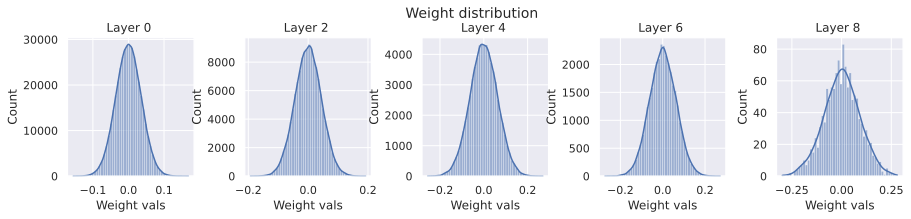

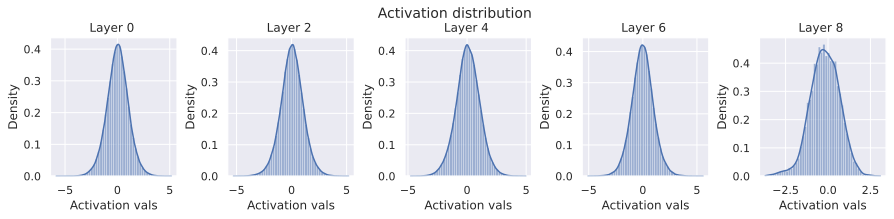

Layer 0 - Variance: 1.0563756227493286
Layer 2 - Variance: 1.0549169778823853
Layer 4 - Variance: 1.0106335878372192
Layer 6 - Variance: 1.0120643377304077
Layer 8 - Variance: 0.7572861909866333


In [54]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0/math.sqrt(param.shape[1]))

equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

As we expected, the variance stays indeed constant across layers. Note that our initialization does not restrict us to a normal distribution, but allows any other distribution with a mean of 0 and variance of $1/d_x$. You often see that a uniform distribution is used for initialization. A small benefit of using a uniform instead of a normal distribution is that we can exclude the chance of initializing very large or small weights.

Besides the variance of the activations, another variance we would like to stabilize is the one of the gradients. This ensures a stable optimization for deep networks. It turns out that we can do the same calculation as above starting from $\Delta x=W\Delta y$, and come to the conclusion that we should initialize our layers with $1/d_y$ where $d_y$ is the number of output neurons. You can do the calculation as a practice, or check a thorough explanation in [this blog post](https://pouannes.github.io/blog/initialization/#mjx-eqn-eqfwd_K). As a compromise between both constraints, [Glorot and Bengio (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi) proposed to use the harmonic mean of both values. This leads us to the well-known Xavier initialization:

$$W\sim \mathcal{N}\left(0,\frac{2}{d_x+d_y}\right)$$

If we use a uniform distribution, we would initialize the weights with:

$$W\sim U\left[-\frac{\sqrt{6}}{\sqrt{d_x+d_y}}, \frac{\sqrt{6}}{\sqrt{d_x+d_y}}\right]$$

Let's shortly implement it and validate its effectiveness:

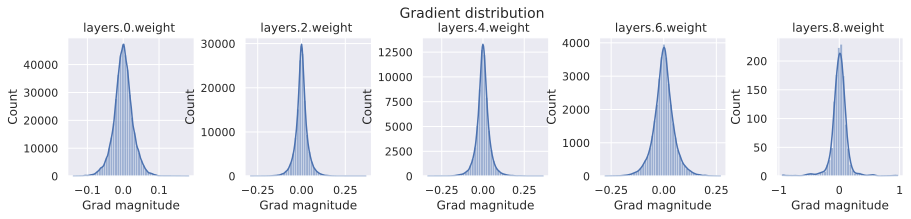

layers.0.weight - Variance: 0.0007123966352082789
layers.2.weight - Variance: 0.0013129538856446743
layers.4.weight - Variance: 0.0017101814737543464
layers.6.weight - Variance: 0.0024509974755346775
layers.8.weight - Variance: 0.021529555320739746


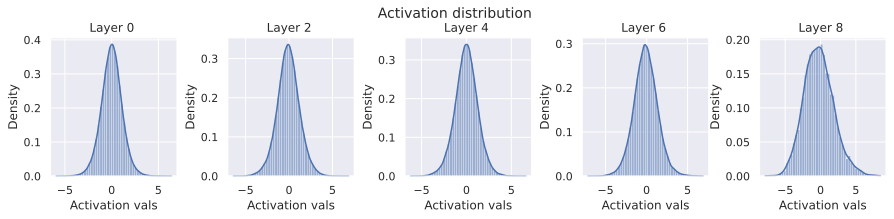

Layer 0 - Variance: 1.2349754571914673
Layer 2 - Variance: 1.6514812707901
Layer 4 - Variance: 1.5861326456069946
Layer 6 - Variance: 2.060638189315796
Layer 8 - Variance: 4.440850257873535


In [55]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1])
            param.data.uniform_(-bound, bound)

xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

We see that the Xavier initialization balances the variance of gradients and activations. Note that the significantly higher variance for the output layer is due to the large difference of input and output dimension ($128$ vs $10$). However, we currently assumed the activation function to be linear. So what happens if we add a non-linearity? In a tanh-based network, a common assumption is that for small values during the initial steps in training, the $\tanh$ works as a linear function such that we don't have to adjust our calculation. We can check if that is the case for us as well:

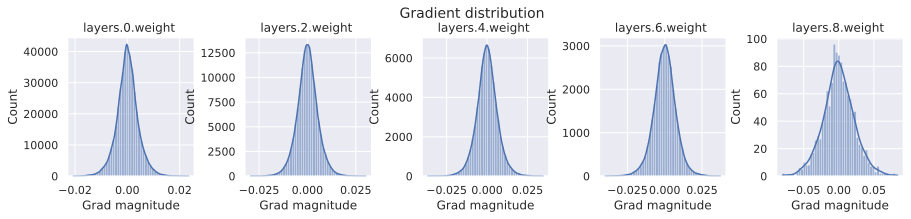

layers.0.weight - Variance: 1.6891248378669843e-05
layers.2.weight - Variance: 2.826713716785889e-05
layers.4.weight - Variance: 4.132005778956227e-05
layers.6.weight - Variance: 5.485919245984405e-05
layers.8.weight - Variance: 0.0004980203229933977


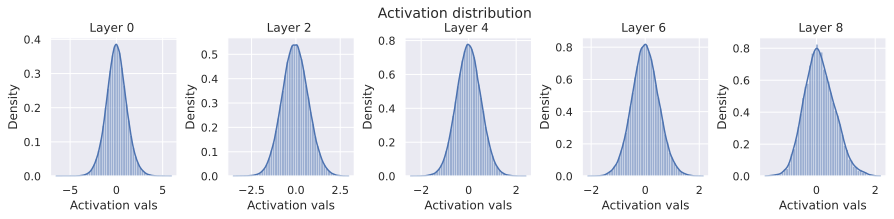

Layer 0 - Variance: 1.2106821537017822
Layer 2 - Variance: 0.5395022630691528
Layer 4 - Variance: 0.26909139752388
Layer 6 - Variance: 0.2471863329410553
Layer 8 - Variance: 0.2661042809486389


In [56]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

Although the variance decreases over depth, it is apparent that the activation distribution becomes more focused on the low values. Therefore, our variance will stabilize around 0.25 if we would go even deeper. Hence, we can conclude that the Xavier initialization works well for Tanh networks. But what about ReLU networks? Here, we cannot take the previous assumption of the non-linearity becoming linear for small values. The ReLU activation function sets (in expectation) half of the inputs to 0 so that also the expectation of the input is not zero. However, as long as the expectation of $W$ is zero and $b=0$, the expectation of the output is zero. The part where the calculation of the ReLU initialization differs from the identity is when determining $\text{Var}(w_{ij}x_{j})$:

$$\text{Var}(w_{ij}x_{j})=\underbrace{\mathbb{E}[w_{ij}^2]}_{=\text{Var}(w_{ij})}\mathbb{E}[x_{j}^2]-\underbrace{\mathbb{E}[w_{ij}]^2}_{=0}\mathbb{E}[x_{j}]^2=\text{Var}(w_{ij})\mathbb{E}[x_{j}^2]$$

If we assume now that $x$ is the output of a ReLU activation (from a previous layer, $x=max(0,\tilde{y})$), we can calculate the expectation as follows:


$$
\begin{split}
    \mathbb{E}[x^2] & =\mathbb{E}[\max(0,\tilde{y})^2]\\
                    & =\frac{1}{2}\mathbb{E}[{\tilde{y}}^2]\hspace{2cm}\tilde{y}\text{ is zero-centered and symmetric}\\
                    & =\frac{1}{2}\text{Var}(\tilde{y})
\end{split}$$

Thus, we see that we have an additional factor of 1/2 in the equation, so that our desired weight variance becomes $2/d_x$. This gives us the Kaiming initialization (see [He, K. et al. (2015)](https://arxiv.org/pdf/1502.01852.pdf)). Note that the Kaiming initialization does not use the harmonic mean between input and output size. In their paper (Section 2.2, Backward Propagation, last paragraph), they argue that using $d_x$ or $d_y$ both lead to stable gradients throughout the network, and only depend on the overall input and output size of the network. Hence, we can use here only the input $d_x$:

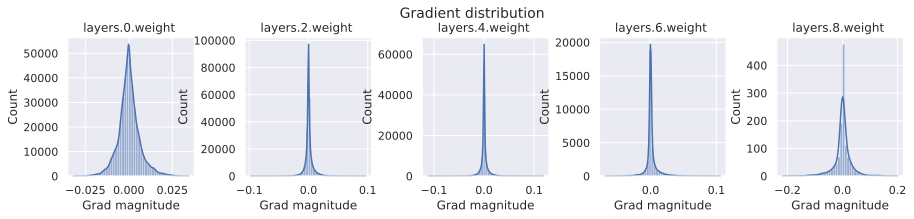

layers.0.weight - Variance: 3.873856985592283e-05
layers.2.weight - Variance: 5.380674701882526e-05
layers.4.weight - Variance: 5.355864414013922e-05
layers.6.weight - Variance: 9.813775250222534e-05
layers.8.weight - Variance: 0.0011569285998120904


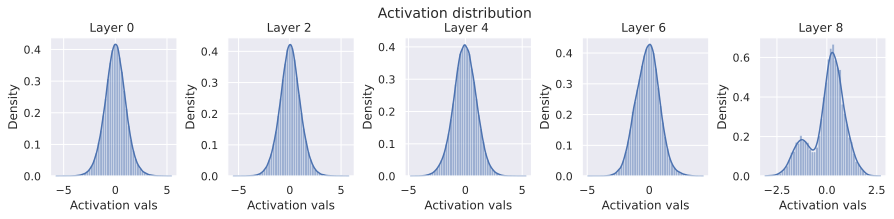

Layer 0 - Variance: 1.0521842241287231
Layer 2 - Variance: 1.031389594078064
Layer 4 - Variance: 1.0104376077651978
Layer 6 - Variance: 0.8919588923454285
Layer 8 - Variance: 0.7389557957649231


In [57]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"): # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1/math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2)/math.sqrt(param.shape[1]))

model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

The variance stays stable across layers. We can conclude that the Kaiming initialization indeed works well for ReLU-based networks. Note that for Leaky-ReLU etc., we have to slightly adjust the factor of $2$ in the variance as half of the values are not set to zero anymore. PyTorch provides a function to calculate this factor for many activation function, see `torch.nn.init.calculate_gain` ([link](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain)).